In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scipy.optimize
from scipy import signal
%matplotlib inline


def to_hex(x, pos):
    return '0x%x' % int(x)

fmt = ticker.FuncFormatter(to_hex)


# MNIST input

In [2]:
import gzip
import numpy as np

def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        f.read(16)  # Skip header
        buf = f.read()
        images = np.frombuffer(buf, dtype=np.uint8).reshape(-1, 784)
    return images

def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        f.read(8)  # Skip header
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

train_d = load_mnist_images("../../GA/train-images-idx3-ubyte.gz")
train_d.shape

(60000, 784)

In [127]:
def add_black_frame(images_28x28):
    num_images = images_28x28.shape[0]
    images_32x32 = np.zeros((num_images, 32, 32), dtype=np.uint8)
    images_32x32[:, 2:30, 2:30] = images_28x28.reshape(-1, 28, 28)
    return images_32x32.reshape(num_images, 1024)

train_inp_d = add_black_frame(train_d)
np.set_printoptions(threshold=2000)  # Adjust as needed
print( train_inp_d[0].reshape(32, 32) )


[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   3  18  18

In [128]:
np.digitize([0,1,12,255,255*2,255*3,255*4],[50,255*2,255*4])

array([0, 0, 0, 1, 2, 2, 3])

In [129]:
def downsample_and_threshold_batch(images_batch, thresholds=[50,255*2,255*4+1]):# threshold=255*2):
    assert images_batch.ndim == 2 and images_batch.shape[1] == 1024, "Input must be (N, 1024)"
    
    # Reshape to (N, 32, 32)
    images_2d = images_batch.reshape(-1, 32, 32)

    # Downsample to (N, 16, 16) by summing over 2x2 blocks
    downsampled = images_2d.reshape(-1, 16, 2, 32).sum(axis=2)
    downsampled = downsampled.reshape(-1, 16, 16, 2).sum(axis=3)

    # Further downsample to (N, 8, 8)
    final = downsampled.reshape(-1, 8, 2, 16).sum(axis=2)
    final = final.reshape(-1, 8, 8, 2).sum(axis=3)

    # Apply threshold
    # binary = (final >= threshold).astype(np.uint8)
    binary = np.digitize(final,thresholds)

    # Return unraveled binary arrays
    return binary.reshape(-1, 64)

train_inp_d = downsample_and_threshold_batch(train_inp_d)
train_inp_d[1].reshape(8,8)

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 3, 2, 0, 0],
       [0, 0, 0, 3, 3, 3, 0, 0],
       [0, 0, 3, 3, 1, 3, 2, 0],
       [0, 0, 3, 0, 0, 3, 1, 0],
       [0, 0, 3, 3, 3, 2, 0, 0],
       [0, 0, 3, 3, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

In [5]:
train_l = load_mnist_labels("../../GA/train-labels-idx1-ubyte.gz")
train_l.shape, train_l[1]

((60000,), 0)

In [6]:
ADC_smpls = 32*32
ADC_smpls = 8*8

ADC_MAX = 255
ADC_MAX = 1

ADC_ZERO = 0


In [7]:

def rand_inp():
    # return np.array(list(np.binary_repr(random.getrandbits( N ), width=N)), dtype=np.uint8) 
    # return SiPM_inp()
    return np.random.randint(low=ADC_ZERO, high=ADC_MAX+1, size=ADC_smpls)

rand_inp()[:10]

array([1, 0, 0, 0, 0, 0, 1, 1, 1, 0])

In [8]:
# def SiPM_ADC(): # Debug
#     Dx = np.linspace(-1,ADC_smpls-2,ADC_smpls)
#     Dy = np.zeros_like(Dx)
#     Dy[Dx >= 64] = ADC_ZERO
#     Dy[Dx < 64] = ADC_MAX
#     # Dx = Dx - Dx[0]
#     Dy = np.digitize(Dy, np.arange(1,ADC_MAX+1))
#     return Dx, Dy

# def Nois_ADC(): # Debug
#     Dx = np.linspace(-1,ADC_smpls-2,ADC_smpls)
#     Dy = np.zeros_like(Dx)
#     Dy[Dx >= 64] = ADC_MAX
#     Dy[Dx < 64] = ADC_ZERO
#     # Dx = Dx - Dx[0]
#     Dy = np.digitize(Dy, np.arange(1,ADC_MAX+1))
#     return Dx, Dy

# def SiPM_inp(): # Debug
#     return np.array([0,1])

# def Nois_inp(): # Debug
#     return np.array([1,0])


# print( list(SiPM_inp()) )

# Define NN

In [139]:
# in bit

inp_len = 8
neur_len = 2
# bias_len = 2
bias_len = 0
wght_len = 2

inp_max = np.uint16((1 << inp_len) - 1)


### Therm
# NN = (8, 10, 10, 4);
# NN = (10, 100, 100, 5);
# NN = (32, 64, 16, 4);
# NN = (128, 64, 32, 4);
# NN = (1024, 64, 4);
# NN = (2048, 64, 32, 4);
# NN = (8, 16, 32, 4);
# NN = (2048, 8, 64, 2); 
# NN = (2048, 4 ,2);
# NN = (2, 8, 2);
# NN = (2, 2);

### MNIST
NN = (ADC_smpls, 64, 32, 10);
NN = (ADC_smpls, 128, 128, 10);
NN = (ADC_smpls, 32, 128, 10);
NN = (ADC_smpls, 32, 16, 10);



# NN = (8192*128, 64, 64, 4);
# NN = (1200, 3000, 100, 4);

keep_l = [None]*len(NN)
# keep_l = (True, True, True, True)
# keep_l = (True, False, False, True)
# keep_l = (False, False, False, False)
# keep_l = (False, False, False)
# keep_l = (False, False)


In [140]:
inp_max

255

In [141]:
NNdescr = "MNIST"

In [142]:
NNstr = NNdescr + " Net: " + "-".join(map(str,NN)) + f", (inp,neur,wght) bits: ({inp_len},{neur_len},{wght_len})"

NNstr

'MNIST Net: 64-32-16-10, (inp,neur,wght) bits: (8,2,2)'

In [143]:
NNfile = NNdescr + " NN_" + "-".join(map(str,NN)) + f"__inp-neur-wght_bits__{inp_len}-{neur_len}-{wght_len}"
NNfile

'MNIST NN_64-32-16-10__inp-neur-wght_bits__8-2-2'

# Make Indi

In [144]:
np.random.binomial(1, 0.1)

0

In [145]:
npNN = np.array(NN)
# npSegm = np.cumsum( np.concatenate( [[0], npNN[:-1]* npNN[1:] * wght_len, npNN[1:] * bias_len] ) )
npSegm = np.cumsum( np.concatenate( [[0], npNN[:-1]* npNN[1:] * wght_len ]) )

def rand_indi_custom(p):
    return np.random.binomial(1, p, size=npSegm[-1])
    
def rand_indi():
    return rand_indi_custom(0.65)
def zero_indi():
    return np.zeros(npSegm[-1])

indi = rand_indi()

npSegm , len(npNN) , len(indi), len(zero_indi()), indi[:10]

(array([   0, 4096, 5120, 5440]),
 4,
 5440,
 5440,
 array([1, 0, 1, 0, 1, 0, 1, 1, 0, 0]))

In [146]:
list( zip( npSegm [:len(npNN)+1],  npSegm [1:len(npNN)] ) )

[(0, 4096), (4096, 5120), (5120, 5440)]

In [147]:
npSegm, len(rand_indi())

(array([   0, 4096, 5120, 5440]), 5440)

In [148]:
def conv_from_indi_to_wght(indi):
    # arr =  np.array( indi ).astype(np.int8) *2 -1
    # iwght = [] 
    # for i,s in enumerate( zip( npSegm [:len(npNN)+1],  npSegm [1:len(npNN)] ) ):
    #     iwght.append( arr[slice(*s)].reshape(npNN[i+1], npNN[i]) )
    # return iwght
    arr =  np.array( indi ).astype(np.int8)
    wghtlist = [] 
    for i,s in enumerate( zip( npSegm [:len(npNN)+1],  npSegm [1:len(npNN)] ) ):
        # print(i,s)
        # iwght = arr[slice(*s)].reshape([2,max(npNN[i+1], npNN[i]),min(npNN[i+1], npNN[i])])
        iwght = arr[slice(*s)].reshape([npNN[i+1], npNN[i],2])
        # print(iwght)
        iwght_2bit = (iwght[:,:,0]) | (iwght[:,:,1] << 1)
        # print(iwght, iwght_2bit)
        wghtlist.append(iwght_2bit)
    return wghtlist
    # arr =  np.array( indi ).astype(np.int8) 
    # biaslist = [] 
    # for i,s in enumerate( zip( npSegm [len(npNN)-1:-1],  npSegm [len(npNN):] ) ):
    #     biasi = arr[slice(*s)].reshape(npNN[i+1],2)
    #     biasi = (biasi[:,0]) | (biasi[:,1] << 1)
    #     biaslist.append( biasi )
    # return biaslist

indi = rand_indi()
[i.shape for i in conv_from_indi_to_wght(indi)], conv_from_indi_to_wght(indi)

# def conv_int_bits(ndarrlist, bits: np.int8):
#     # arr = np.asarray(ndarrlist)

#     if bits <= 1:
#         return ndarrlist
#     elif bits >= 2:
#         shifts = np.arange(bits-1, -1, -1)
#         print(shifts)
#         # return [np.column_stack([(a >> 2) & 1,(a >> 1) & 1, a & 1]).astype(np.uint8) for a in ndarrlist ]
#         return [[(a >> i) & 1 for i in shifts] for a in ndarrlist]
#         return (ndarrlist[:, None] >> shifts) & 1    
#     #     return [np.column_stack([(a >> 1) & 1, a & 1]) for a in ndarrlist ]
#     # elif bits == 3:
#     #     return [np.column_stack([(a >> 2) & 1,(a >> 1) & 1, a & 1]) for a in ndarrlist ]
        
# conv_int_bits(rand_NNbias(), bias_len), conv_int_bits(rand_NNwgth(), wght_len)

([(32, 64), (16, 32), (10, 16)],
 [array([[1, 3, 3, ..., 2, 1, 3],
         [2, 1, 3, ..., 1, 2, 2],
         [1, 2, 0, ..., 3, 2, 0],
         ...,
         [3, 3, 2, ..., 0, 3, 1],
         [1, 2, 3, ..., 1, 1, 2],
         [2, 3, 0, ..., 3, 2, 3]], dtype=int8),
  array([[1, 1, 3, 0, 3, 2, 1, 2, 1, 1, 2, 3, 3, 0, 2, 3, 3, 3, 1, 3, 3, 1,
          3, 3, 3, 2, 2, 1, 2, 3, 3, 3],
         [0, 3, 1, 3, 3, 0, 3, 1, 1, 3, 0, 3, 0, 1, 0, 3, 2, 3, 3, 0, 1, 3,
          3, 2, 3, 3, 1, 3, 2, 3, 1, 2],
         [3, 2, 3, 1, 1, 1, 3, 3, 1, 3, 3, 1, 3, 2, 2, 3, 3, 3, 2, 3, 3, 1,
          0, 1, 3, 1, 1, 1, 0, 2, 3, 1],
         [3, 0, 1, 2, 2, 1, 3, 1, 2, 1, 3, 1, 2, 2, 3, 3, 2, 2, 2, 3, 3, 2,
          2, 2, 2, 3, 1, 1, 3, 2, 3, 0],
         [2, 0, 1, 2, 1, 3, 3, 2, 3, 2, 3, 3, 3, 3, 2, 3, 2, 1, 3, 3, 0, 3,
          3, 3, 3, 3, 3, 3, 2, 3, 3, 3],
         [3, 3, 2, 3, 2, 1, 0, 1, 2, 3, 2, 1, 2, 1, 3, 0, 3, 3, 3, 3, 0, 1,
          1, 3, 3, 3, 1, 2, 3, 3, 2, 2],
         [2, 3, 1, 3, 1, 2, 3, 3,

In [149]:
npSegm, npSegm[len(npNN):]

(array([   0, 4096, 5120, 5440]), array([], dtype=int64))

In [150]:
# NNsummap = [(int(NN[L]*3*1/4) , int(NN[L]*3*1/2) , int(NN[L]*3*3/4)) for L in range(0,len(NN)-1)] 
# print(NNsummap)


In [151]:
# def ensure_strictly_monotonic_rows(arr):
#     arr = arr.copy()  # avoid modifying original
#     # Step 1: ensure b > a
#     arr[:, 1] = np.maximum(arr[:, 1], arr[:, 0] + 1)
#     # Step 2: ensure c > b
#     arr[:, 2] = np.maximum(arr[:, 2], arr[:, 1] + 1)
#     return arr

def conv_from_indi_to_summap(indi):
    summap = []
    for i in range(0,len(NN)-1):
        nonzwght = (npNN[i] - np.uint8(conv_from_indi_to_wght(indi)[i] == 0).sum(axis = 1))
        # print(nonzwght)
        if i==0:
            summap.append( np.uint32( nonzwght[:,np.newaxis] * [0.25, 0.5, 0.75] * (ADC_MAX)) )
        else:
            summap.append( np.uint32( nonzwght[:,np.newaxis] * [0.5, 1.5, 2.5]) )
        # summap[-1] = ensure_strictly_monotonic_rows(summap[-1])
    return summap

conv_from_indi_to_summap(indi)

[array([[15, 30, 45],
        [15, 30, 45],
        [13, 26, 39],
        [13, 27, 41],
        [15, 30, 45],
        [14, 28, 42],
        [14, 29, 43],
        [13, 26, 39],
        [13, 26, 39],
        [14, 28, 42],
        [14, 28, 42],
        [13, 27, 40],
        [13, 27, 41],
        [14, 28, 42],
        [14, 28, 42],
        [14, 28, 42],
        [13, 27, 41],
        [14, 29, 44],
        [14, 28, 42],
        [14, 28, 42],
        [14, 28, 42],
        [15, 30, 45],
        [15, 30, 45],
        [12, 25, 38],
        [14, 28, 42],
        [15, 30, 45],
        [14, 28, 42],
        [13, 26, 39],
        [14, 28, 42],
        [14, 28, 42],
        [15, 30, 45],
        [15, 31, 46]], dtype=uint32),
 array([[15, 45, 75],
        [13, 39, 65],
        [15, 45, 75],
        [15, 45, 75],
        [15, 45, 75],
        [14, 43, 72],
        [15, 45, 75],
        [14, 42, 70],
        [14, 42, 70],
        [14, 43, 72],
        [14, 43, 72],
        [14, 43, 72],
        [14, 42,

In [22]:
NNsummap = conv_from_indi_to_summap(indi)

# Generate NN parameters

In [23]:
Ws = [NN[i]*NN[i+1] for i in range(len(NN)-1)]
Bs = [NN[i] for i in range(1,len(NN))] # Max 0..3 * N_inputs
print("Weights: ",Ws, ", Biases: ", Bs)

NNbits = sum(Ws) * wght_len + sum(Bs) * bias_len
print(NNbits)

Weights:  [2048, 4096, 1280] , Biases:  [32, 128, 10]
14848


In [24]:
indi = rand_indi_custom(0.1)

In [25]:
NNwgth = conv_from_indi_to_wght(indi)
# NNbias = conv_from_indi_to_bias(indi)
NNsummap = conv_from_indi_to_summap(indi)
# del rand_NNwgth
# del rand_NNbias


# Python NN Forward calc 

In [26]:
# in bit
# neur_len = 2
# bias_len = 2
# wght_len = 1

# NN = (1024, 64, 32, 4);


In [27]:
verbose = False


In [28]:
import time


In [29]:
if type(conv_from_indi_to_wght(indi)[0]) == np.ndarray:
    print(1)

1


In [30]:
# ----------------------------------------------------------------------
# LUT that implements the 4×4 bias‑addition table
#   a = neuron sum (0‑3)   b = bias (0‑3)
#   out = a + b  (saturated at 3)
# ----------------------------------------------------------------------
_CAM_LUT = np.array([ # with input 0, 1, 2 ,3
    3, 2, 1, 0,   # bias = 0, n = 0..3
    0, 0, 1, 2,   # bias = 1, n = 0..3
    0, 1, 2, 3,   # bias = 2, n = 0..3
    1, 2, 3, 3    # bias = 3, n = 0..3
], dtype=np.uint8)          # shape (16,)

_CAM_LUT = np.array([ # with input 0, 1, 2 ,3
    0, 0, 0, 0,   # wght = 0, n = 0..3 => Block
    0, 1, 2, 3,   # wght = 1, n = 0..3 => Pass
    1, 2, 3, 3,   # wght = 2, n = 0..3 => Inc
    3, 2, 1, 0,   # wght = 3, n = 0..3 => Neg
], dtype=np.uint8)          # shape (16,)

# _BiasInput_LUT = np.array([ # with input 0, 1, 2 ,3
#     0, 0,   # bias = 0 Blk, n = 0..1
#     1, 0,   # bias = 1 Neg, n = 0..1
#     0, 1,   # bias = 2 Pas, n = 0..1
#     1, 1,   # bias = 3 Inc, n = 0..1
# ], dtype=np.uint8)          # shape (16,)

def CAM_neur(neur: np.ndarray, wght: np.ndarray) -> np.ndarray: 
    # The index into the 4‑bit LUT is   idx = a*4 + b  == (a << 2) | b
    idx = (wght << 2) | neur          # still uint8, range 0‑15
    return _CAM_LUT[idx]            # vectorised lookup, result shape = (n_next,)

# def bias_input(inp: np.ndarray, bias: np.ndarray) -> np.ndarray: 
#     # Inputs: vectors of a and b in [0..3]
#     a = np.array(inp, dtype=np.uint8)
#     b = np.array(bias, dtype=np.uint8)

#     # Both a and b are 1‑D arrays of the same length (n_next).
#     # The index into the 4‑bit LUT is   idx = a*4 + b  == (a << 2) | b
#     idx = (bias << 1) | inp          # still uint8, range 0‑15
#     return _BiasInput_LUT[idx]            # vectorised lookup, result shape = (n_next,)

In [31]:
[ CAM_neur(np.array([0,1,2,3]), wght) for wght in np.array([[0,0,0,0],[1,1,1,1],[2,2,2,2],[3,3,3,3]])] 

[array([0, 0, 0, 0], dtype=uint8),
 array([0, 1, 2, 3], dtype=uint8),
 array([1, 2, 3, 3], dtype=uint8),
 array([3, 2, 1, 0], dtype=uint8)]

In [32]:
np.uint16((1 << inp_len ) - 1)

255

In [33]:
dtype = np.uint16

def blk(inp):
    return np.zeros_like(inp)#, dtype=dtype)

def pas(inp):
    x = np.array(inp)#, dtype=dtype)
    return x

def inc(inp):
    x = np.array(inp)#, dtype=dtype)
    # return np.clip(x * 2, 0, 127)
    return np.minimum(x << 1, np.uint16((1 << inp_len ) - 1))

def neg(inp, bits=7):
    x = np.array(inp)
    tmp = np.bitwise_not(x)        # ~x
    # tmp = np.add(tmp, 1, dtype=dtype)             # ~x + 1
    result = np.bitwise_and(tmp, inp_max)   # (& mask)
    return result

case4 = {0: blk, 1: neg, 2: pas, 3: inc}


def CAM_inp_scalar(inp, wght):
    return case4[wght](inp)

CAM_inp = np.vectorize(CAM_inp_scalar)

inp = train_d[0]
[CAM_inp(inp,i) for i in [0,1,2,3]]
# CAM_inp(inp,[0,1,2,3])

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [34]:
indi = np.zeros(npSegm[-1])
indi = rand_indi()
indi[0] = 1
wght = conv_from_indi_to_wght(indi)[0]
print(wght)

# np.apply_along_axis(func1d=CAM_neur, axis=1, arr=np.array([[0,0],[0,1],[1,0],[1,1]]), wght=wght)



[[3 1 2 ... 2 3 3]
 [3 2 1 ... 2 3 2]
 [3 1 1 ... 2 3 2]
 ...
 [0 0 0 ... 2 1 2]
 [0 1 0 ... 3 1 3]
 [0 2 1 ... 3 3 2]]


In [35]:
wght = conv_from_indi_to_wght(indi)[1]
# CAM_neur(np.array([0,1,0,2]), wght)

### Calc Layer

In [36]:
(np.array([0,1,2,3])>=2).astype(np.uint8)

array([0, 0, 1, 1], dtype=uint8)

In [130]:
import time

def layer_inp(input_i):
    # return np.uint8(input_i+1)
    return np.uint8(input_i)

def output_o(layer_nL):
    return (layer_nL>=2).astype(np.uint8)
    # bit0 = layer_nL & 1
    # bit1 = (layer_nL >> 1) & 1
    # # Interleave: [bit0[0], bit1[0], bit0[1], bit1[1], ...]
    # zipped = np.empty(bit0.size * 2, dtype=bit0.dtype)
    # zipped[0::2] = bit0
    # zipped[1::2] = bit1
    # return zipped



# def calc_layer_old(layer_pre, layer_pre_idx, NNwgth, NNbias, NNsummap):
#     layer_nN_sum = np.clip(  # calc next layer n+1
#         np.add( # weigh neuron value (0..3) up or down (-1;1) 
#             # NNwgth_calc, # weights n -> n+1
#             NNwgth[layer_pre_idx+0],  # weights n -> n+1
#             np.broadcast_to( # same input for all NN[n+1] next layer neurons
#                 layer_pre, (NN[layer_pre_idx+1],NN[layer_pre_idx])
#             ).reshape(1,-1)  # broadcast_to returns a NxM view, but we need 1d
#             , dtype=np.int8)
#         , 0,3).reshape( # clip parameters = inclusive range
#         -1, NN[layer_pre_idx+0]).sum( # sum over M neurons of next layer
#         axis=1)  # clip 0..3
    
#     return np.digitize(layer_nN_sum + NNbias[layer_pre_idx+1], NNsummap[layer_pre_idx+0], dtype=np.uint8)

digitize_func = np.vectorize(lambda x, y: np.digitize(x, y), signature='(n),(n,m)->(n)')

# --------------------------------------------------------------
# Vectorised digitise  (equivalent to np.digitize(..., side='right'))
# --------------------------------------------------------------
def digitise_rows(neuron_sum: np.ndarray, bin_edges: np.ndarray) -> np.ndarray:
    # Expand dimensions so broadcasting works:
    #   neuron_sum[..., None]  → (R, C, 1)
    #   bin_edges[:, None, :]  → (R, 1, B)
    # Comparison is then performed row‑wise.
    greater_equal = neuron_sum[..., None] >= bin_edges[:, None, :]
    # print(greater_equal.shape)

    # For each value we count how many edges are ≤ that value.
    # The count is exactly the digitise index when side='right'.
    idx = greater_equal.sum(axis=2)          # shape (R, C)
    # print(idx.shape)

    return idx
d = None
def calc_layer(
    layer_pre: np.ndarray,
    layer_pre_idx: int,
    NNwgth: list[np.ndarray],
    NNsummap: list[np.ndarray],
) -> np.ndarray:
    """
    Compute the activations of the next layer in a simple feed-forward network.

    Returns
    -------
    np.ndarray, dtype uint8, shape (n_next,)
        The digitised activations of the next layer.
    """
    if verbose:
        print("* Input:")
        print(layer_pre.shape, layer_pre.mean(), layer_pre.std())

        time.sleep(0.001)
    # ------------------------------------------------------------------ #
    weights = NNwgth[layer_pre_idx]
    if verbose:
        print("* weights:")
        print(weights.tolist()) #[:min(10,len(weighted[layer_pre_idx])-1)]
        print(weights.shape, weights.mean(), weights.std())
        time.sleep(0.001)

    if layer_pre_idx == 0:
        weighted = CAM_neur(layer_pre, weights)
        # weighted = CAM_inp(layer_pre, weights)
        # weighted = np.fromiter(    (CAM_inp(x, w) for x, w in zip(layer_pre, weights)),    dtype=np.uint8)
    else:
        weighted = CAM_neur(layer_pre, weights)
    # global d
    # d=weighted[:]
    if verbose:
        print("* weighted:")
        print(weighted.tolist()) #[:min(10,len(weighted[layer_pre_idx])-1)]
        print(weighted.shape, weighted.mean(), weighted.std())
        time.sleep(0.001)
    
    # ------------------------------------------------------------------ #
    neuron_sum = weighted.sum(axis=1)               # shape (n_next,)
    if verbose:
        print("* neuron_sum:")
        print(neuron_sum.tolist())
        print(neuron_sum.shape, neuron_sum.mean(), neuron_sum.std())
        
    
    # ------------------------------------------------------------------ #
    bin_edges = NNsummap[layer_pre_idx]            # shape (n_next, n_bins)
    if verbose:
        print("* bin_edges:")
        print(bin_edges.tolist())#[:min(2,len(bin_edges)-1)])
        print(bin_edges.shape)
    try:
        # ReLu_2bit = digitize_func(neuron_sum, bin_edges)
        # ReLu_2bit = np.apply_along_axis(lambda a, b: np.digitize(a, b), 1, neuron_sum, bin_edges)
        # ReLu_2bit = np.array( [ np.digitize(neuron_sum[i], b) for i,b in enumerate(bin_edges) ] )
        # ReLu_2bit = (neuron_sum[..., None] >= bin_edges[:, None, :]).sum(axis=2)
        # ReLu_2bit = digitise_rows(neuron_sum, bin_edges)
        ReLu_2bit = np.fromiter(    (np.digitize(x, b) for x, b in zip(neuron_sum, bin_edges)),    dtype=np.uint8)
    except Exception:
        print(neuron_sum, bin_edges)
        ReLu_2bit = np.zeros_like(neuron_sum)
    
    if verbose:
        print("* ReLu_2bit:")
        # print(list(bin_edges)[:min(10,len(bin_edges)-1)], ReLu_2bit.shape)

    neurons_next = ReLu_2bit
    
    return neurons_next
    




layer_n0 = rand_inp()
# verbose = False
verbose = True
layer_n1 = calc_layer( layer_n0, 0, NNwgth, NNsummap) 
verbose = True
# layer_n2 = calc_layer( layer_n1, 1, NNwgth, NNbias, NNsummap) 
# layer_n3 = calc_layer( layer_n2, 2, NNwgth, NNbias, NNsummap) 
verbose = False

layer_n1

* Input:
(64,) 0.453125 0.4977978850648122
* weights:
[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 2, 0, 1, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 0, 0, 0, 2, 0, 3, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0, 1, 0, 3, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2], [0, 0, 1, 2, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

array([3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=uint8)

In [38]:
2**8

256

In [131]:
bin_edges = np.array([[ 28,  84, 140],
        [ 28,  85, 142],
        [ 31,  102, 155],
        [ 28,  85, 142],
        [ 26,  79, 132]])
neuron_sum = np.array( [[30,10,100],[20,10,100],[20,10,100],[40,10,100],[1,10,100]] )
# np.digitize([1,10,100], bin_edges)
# np.apply_along_axis(func1d=np.digitize, axis=1, arr=d, bins=bin_edges)
# np.apply_along_axis(lambda a, b: np.digitize(a, b), 0, neuron_sum, bin_edges)
# digitize_func(neuron_sum, bin_edges)



In [132]:
verbose=False

In [41]:
# %timeit calc_layer( calc_layer( calc_layer( rand_inp(), 0, NNwgth, NNbias, NNsummap) , 1, NNwgth, NNbias, NNsummap) , 2, NNwgth, NNbias, NNsummap) 
%timeit  calc_layer( rand_inp(), 0, NNwgth, NNsummap) 


3.19 ms ± 137 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
%load_ext line_profiler
# %lprun -f calc_layer calc_layer( calc_layer( calc_layer( rand_inp(), 0, NNwgth, NNbias, NNsummap) , 1, NNwgth, NNbias, NNsummap) , 2, NNwgth, NNbias, NNsummap) 
%lprun -f calc_layer calc_layer(calc_layer( rand_inp(), 0, NNwgth, NNsummap), 1, NNwgth, NNsummap)


Timer unit: 1e-09 s

Total time: 0.0150626 s
File: /tmp/ipykernel_1137971/2250938404.py
Function: calc_layer at line 54

Line #      Hits         Time  Per Hit   % Time  Line Contents
    54                                           def calc_layer(
    55                                               layer_pre: np.ndarray,
    56                                               layer_pre_idx: int,
    57                                               NNwgth: list[np.ndarray],
    58                                               NNsummap: list[np.ndarray],
    59                                           ) -> np.ndarray:
    60                                               """
    61                                               Compute the activations of the next layer in a simple feed-forward network.
    62                                           
    63                                               Returns
    64                                               -------
    65            

In [43]:
NNwgth[0].shape, \
conv_from_indi_to_wght(indi)[0].shape

((32, 64), (32, 64))

### Run NN: recursive layer calc

In [133]:

def run_NN(inp, pars):
    global NN
    # NN, NNwgth, NNbias, NNsummap = pars
    NNwgth,NNsummap  = pars
    layer_ni = layer_inp(inp)
    for i in range(0,len(NN)-1):
        layer_ni = calc_layer( layer_ni, i, NNwgth,  NNsummap)
    return output_o(layer_ni)

# run_NN(rand_inp(NN[0]), pars=(NNwgth,NNsummap)), \
verbose = True
# run_NN(rand_inp(NN[0]), pars=(NNwgth,conv_from_indi_to_summap(rand_indi()) )), \
run_NN(rand_inp(), pars=(conv_from_indi_to_wght(rand_indi()),conv_from_indi_to_summap(rand_indi()) ))



* Input:
(64,) 0.5 0.5
* weights:
[[3, 1, 1, 3, 0, 1, 2, 3, 1, 3, 0, 0, 3, 1, 3, 3, 2, 2, 0, 3, 3, 1, 1, 1, 3, 0, 1, 3, 0, 2, 3, 3, 0, 3, 1, 3, 2, 1, 1, 3, 0, 1, 2, 2, 0, 2, 1, 2, 1, 2, 3, 0, 3, 3, 3, 3, 2, 0, 3, 3, 3, 3, 0, 3], [2, 3, 1, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 0, 3, 3, 1, 2, 1, 0, 3, 1, 3, 1, 0, 3, 2, 3, 3, 1, 0, 3, 1, 1, 0, 3, 3, 1, 3, 3, 3, 0, 0, 3, 3, 1, 3, 1, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3], [1, 3, 3, 1, 3, 2, 3, 3, 3, 3, 1, 2, 2, 3, 2, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 2, 3, 1, 3, 3, 2, 1, 3, 3, 3, 0, 3, 3, 0, 3, 3, 3, 1, 2, 2, 3, 2, 1, 3, 1, 3, 3, 0, 2, 3, 2, 3, 3, 3, 3, 3, 1, 3, 3], [3, 3, 1, 0, 2, 2, 3, 3, 3, 3, 2, 3, 1, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 3, 1, 0, 0, 1, 3, 1, 2, 0, 2, 2, 2, 0, 2, 1, 3, 3, 1, 3, 3, 2, 1, 0, 0, 3, 1, 3, 1, 0, 1, 3, 2, 3, 2, 2, 3, 1, 0], [3, 3, 3, 1, 2, 2, 2, 1, 3, 3, 3, 3, 1, 3, 3, 2, 1, 3, 3, 3, 0, 3, 3, 1, 1, 2, 0, 2, 0, 1, 3, 2, 2, 2, 2, 1, 1, 1, 3, 2, 3, 2, 3, 3, 0, 3, 1, 3, 3, 3, 2, 1, 3, 3, 1, 3, 1, 1, 2, 3, 3, 3, 2,

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8)

In [45]:
verbose = False

In [46]:
%timeit run_NN(rand_inp(), (NNwgth, NNsummap))

4.7 ms ± 185 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [47]:
%load_ext line_profiler
%lprun -f run_NN run_NN(rand_inp(), (NNwgth, NNsummap))

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Timer unit: 1e-09 s

Total time: 0.020473 s
File: /tmp/ipykernel_1137971/4011328635.py
Function: run_NN at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def run_NN(inp, pars):
     2                                               global NN
     3                                               # NN, NNwgth, NNbias, NNsummap = pars
     4         1        889.0    889.0      0.0      NNwgth,NNsummap  = pars
     5         1       7876.0   7876.0      0.0      layer_ni = layer_inp(inp)
     6         4       3405.0    851.2      0.0      for i in range(0,len(NN)-1):
     7         3   20447771.0 6.82e+06     99.9          layer_ni = calc_layer( layer_ni, i, NNwgth,  NNsummap)
     8         1      13033.0  13033.0      0.1      return output_o(layer_ni)

In [48]:
verbose = False

In [49]:
# !pip install line-profiler

In [50]:
run_NN

<function __main__.run_NN(inp, pars)>

In [51]:
# np.sum( Train_Res, axis=1).shape

In [52]:
def run_NN_from_indi(data, indi, NN = NN):
    return np.apply_along_axis(func1d=run_NN, axis=1, arr=data, pars=(conv_from_indi_to_wght(indi), conv_from_indi_to_summap(indi)))




In [53]:
# rand_NNwgth(), [np.column_stack([(a >> 1) & 1, a & 1]) for a in rand_NNbias() ]

In [54]:
# Ws = [NN[i]*NN[i+1] for i in range(len(NN)-1)]
# Bs = [NN[i] for i in range(len(NN))] # Max 0..3 * N_inputs
print("Weights: ",Ws, ", Biases: ", Bs)

# NNbits = sum(Ws) * wght_len + sum(Bs) * bias_len
print(NNbits)

Weights:  [2048, 4096, 1280] , Biases:  [32, 128, 10]
14848


# Calc fitness

In [55]:
np.shape(rand_indi()), np.shape(indi)

((14848,), (14848,))

In [56]:
First = True
First = False

In [57]:
if "hof" in globals():
    indi = hof[0]
else:
    indi = rand_indi()
# indi[:10], indi[-10:], conv_from_indi_to_wght(indi)[0][0][:10]

In [58]:
NN[0]

64

In [134]:
lenTrain_D_good = 5000
# lenTrain_D_bad = 100

def gen_Data_Label(size=lenTrain_D_good):
    rndchoice = np.random.choice(np.arange(len(train_l)), size = size)
    return train_inp_d[rndchoice], train_l[rndchoice]
    
subtrain_d, subtrain_l = gen_Data_Label()

len_Train = len(subtrain_d)
subtrain_d.shape, subtrain_l.shape

((5000, 64), (5000,))

In [60]:
%timeit gen_Data_Label()

141 μs ± 8.59 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [61]:
verbose = False
indi = [0,1]*int(len(indi)/2)

run_NN_from_indi(subtrain_d,indi)


array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [62]:
verbose = False

In [63]:
indi = rand_indi()
run_NN_from_indi(subtrain_d, indi)

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

In [64]:

def softmax(z):
    e = np.exp(z - np.max(z))
    return e / e.sum()

def softmax(z):
    # e = np.exp(z - np.max(z))
    return z / z.sum()

# def fitness_from_logits(logits, target):
#     p = softmax(logits)
#     # print(p)
#     p_t = p[target]
#     # print(p_t)
#     p_max2 = np.max(np.delete(p, target))
#     return p_t, p_max2 #(1.0 + p_t - p_max2) / 2.0

def on_target_single(nn_out, target):
    active_indices = np.where(nn_out != 0)[0].tolist()
    if target in active_indices:
        score = 1.0 / len(active_indices)
    else:
        score = 0.0
    return score # ,active_indices



def on_target(nn_outs, labels):
    active_mask = np.asanyarray(nn_outs) != 0
    active_indices = [np.where(row)[0].tolist() for row in active_mask]
    match_scores = np.array([
        1.0 / len(indices) if label in indices else 0.0
        for indices, label in zip(active_indices, labels)
    ])
    return match_scores # ,active_indices


l = np.array( [0,0,0,0,0,0,0,0,1,0])
t0= np.array( [0,0,0,0,0,0,0,0,1,0])
t1= np.array( [0,0,0,0,0,0,0,0,1,0])
t2= np.array( [0,0,0,0,0,0,0,0,0,1] ,dtype=np.float32)
t3= np.array( [0,0,0,0,0,0,0,1,1,1] ,dtype=np.float32)

# fitness_from_logits(l,0), fitness_from_logits(l,1), fitness_from_logits(l,2)
on_target_single(t0,9),on_target_single(t1,9),on_target_single(t2,9),on_target([t1,t2,t3],[9,9,9])

(0.0, 0.0, 1.0, array([0.        , 1.        , 0.33333333]))

In [65]:
# np.apply_along_axis(func1d=run_NN, axis=1, arr=Train_D_good, pars=(conv_from_indi_to_wght(indi), conv_from_indi_to_summap(indi) ))

In [66]:
run_NN_from_indi?

Signature: run_NN_from_indi(data, indi, NN=(64, 32, 128, 10))
Docstring: <no docstring>
File:      /tmp/ipykernel_1137971/909124790.py
Type:      function

In [152]:
def fitness(indi, tests=10):

    subtrain_d, subtrain_l = gen_Data_Label(tests)

    
    res = run_NN_from_indi(subtrain_d, indi)
    
    # res_g = np.apply_along_axis(func1d=run_NN, axis=1, arr=Train_D_good, pars=(conv_from_indi_to_wght(indi),  conv_from_indi_to_summap(indi)))
    how_good = on_target(res,subtrain_l)

    how_flipped = on_target((~res.astype(bool)).astype(int),subtrain_l) 

    # how_distinct = np.sum(np.int8(res_g[:lendistinct]!=res_b[:lendistinct]))

    # return (good + bad)
    # return failed_good + failed_bad

    # if verbose:
    #     print( res_g )
    
    # if verbose:
    #      print( how_good , how_bad , how_distinct, len_Train )
    # return (how_good / lenTrain_D_good  +  how_bad / lenTrain_D_bad  +  how_distinct / lendistinct ) 
    return np.sum(how_good + how_flipped) / tests


# verbose=True
verbose=False
f=fitness(indi)
verbose=False

indi[:10],  f

(array([1, 0, 1, 1, 1, 1, 1, 0, 0, 1]), 0.1)

In [68]:
%%time
fitness(indi)

CPU times: user 51.3 ms, sys: 8 μs, total: 51.3 ms
Wall time: 51.1 ms


0.1

In [69]:
len_Train

5000

In [70]:
First = True
First = False

In [71]:
if First:
    verbose=False
    nf = fitness(rand_indi())
    for i in range(100):
        indi = rand_indi()
        f = fitness(indi)
        if f != nf:
            print(f,nf,indi)
        nf = f
First = False

In [72]:
indi = [0,1]*int(len(indi)/2)
fitness(indi)

0.1

In [73]:
verbose=False
# indi = hof[0]
# fitness(indi)
%timeit fitness(indi)

22.4 ms ± 482 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [153]:
First = True

if First:
        
    prob_tst_Ntries = 100
    prob_tst_Nbins = 20
    prob_tst_Ntests = 100
    
    typical_rand_fitness = np.median([fitness(rand_indi_custom(0.5),prob_tst_Ntests) for i in range(5)])
    print ("Typical: ",typical_rand_fitness)
    prob_tst=[np.linspace(0,1,1+prob_tst_Nbins)[1:-1],[],[]]
    for p in prob_tst[0]:
        print(f", {p:g}", end='' )
        p_nontriv = 0
        p_nontriv_std = 0
        for i in range(prob_tst_Ntries):
            indi = rand_indi_custom(p)
            # f,res_g,res_b = fitness_fast(indi)
            f = fitness(indi,prob_tst_Ntests)
            # print(p, f , end=None)
            # if np.abs(f - typical_rand_fitness)/typical_rand_fitness > 0.01 :
            if f != typical_rand_fitness :
                p_nontriv += 1
                p_nontriv_std += f
                # plt.hist(res_g)
                # plt.scatter(res_g, res_b)
        if p_nontriv>0:
            print("# ", end='' )
            
        prob_tst[1].append(p_nontriv/prob_tst_Ntries)
        prob_tst[2].append(p_nontriv_std)



Typical:  0.09999999999999998
, 0.05# , 0.1# , 0.15# , 0.2# , 0.25# , 0.3# , 0.35# , 0.4# , 0.45# , 0.5# , 0.55# , 0.6# , 0.65# , 0.7# , 0.75# , 0.8, 0.85, 0.9, 0.95

In [154]:
[np.linspace(0,1,11)[1:-1],[],[]]


[array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), [], []]

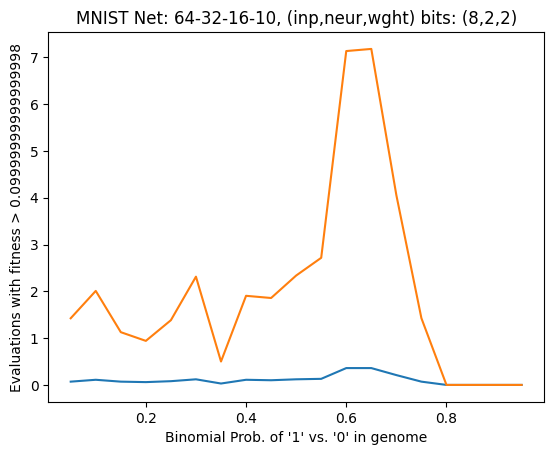

In [155]:
# First=True
if First:
    
    plt.plot(prob_tst[0],prob_tst[1], label=f"N > {typical_rand_fitness}")
    plt.plot(prob_tst[0],prob_tst[2], label="std")
    plt.xlabel("Binomial Prob. of '1' vs. '0' in genome")
    plt.ylabel(f"Evaluations with fitness > {typical_rand_fitness}")
    plt.title(NNstr)
    First = False


In [ ]:
NNwgth[0].shape

# Setup GA

In [ ]:
!pip install deap


In [89]:
import random
from deap import base, creator, tools, algorithms


In [90]:
# def selTournamentWithFitBracket(individuals, k, tournsize, toolbox, max_fitness = None, min_fitness = None):
#     selected = tools.selTournament(individuals, k, tournsize)
#     # 2) Replace low-fitness winners
#     for i, ind in enumerate(selected):
#         # DEAP stores fitness as a tuple (even for a single objective)
#         # If the individual has never been evaluated, fitness is invalid - treat as low.
#         if not ind.fitness.valid or (min_fitness and ind.fitness.values[0] < min_fitness) or (max_fitness and ind.fitness.values[0] > max_fitness):
#             # ---- create a brand-new random individual -----------------
#             new_ind = toolbox.individual()
#             # ---- (optional) evaluate it now ---------------------------
#             # If you want the algorithm to evaluate it later, just comment the line below.
#             # new_ind.fitness.values = toolbox.evaluate(new_ind)
#             # ---- replace the low-fit individual -----------------------
#             selected[i] = new_ind
#     return selected

def selTournamentWithFitBracket(individuals, k, tournsize, max_fitness = None, min_fitness = None):
    pop = tools.selTournament(individuals, k, tournsize)
    # 2) Replace low-fitness winners
    sub_pop = [ind for ind in pop if (min_fitness and ind.fitness.values[0] < min_fitness) or (max_fitness and ind.fitness.values[0] > max_fitness)]
    return sub_pop


In [188]:
def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, elites = 0, verbose=__debug__): # 

    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])
    logbook.genlog = []

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)
    if len(halloffame) < elites:
        elites = len(halloffame)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)
        if len(population)>len(offspring):
            fillers = algorithms.varAnd(offspring[:], toolbox, cxpb, mutpb)[:len(population)-len(offspring)]
            offspring.extend(fillers)

            

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        
        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            # reevaluate HOF
            fitnesses = toolbox.map(toolbox.evaluate, halloffame)
            for ind, fit in zip(halloffame, fitnesses):
                ind.fitness.values = fit
            
            # after reevaluation, update HOF with possibly changed fitness
            halloffame.update(halloffame)
            halloffame.update(offspring)
            if elites>0:
                offspring = offspring[:-elites]
                offspring.extend(halloffame.items[:elites])
        
        # Replace the current population by the offspring
        population[:] = offspring
        
        # if elites > 0 and elites <= len(population) and elites <= len(hof):
        #     population[-elites:] = halloffame[:]

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        logbook.genlog.append(tools.selBest(population, 1)[0])
        if verbose:
            print(logbook.stream)

    return population, logbook

In [189]:
def eval_size(individual):
    zero_genes = np.sum( [len(np.where( np.ravel( i )==0)[0]) for i in conv_from_indi_to_wght(individual)] )
    return zero_genes  / ( len(individual)/2)


In [190]:
import time
from dateutil.relativedelta import relativedelta
time.time()

import multiprocessing
pool = multiprocessing.Pool(12)


# --- Constants ---
GENOME_LENGTH = npSegm[-1]
POP_SIZE = 300
CXPB = 0.7  # Crossover probability
MUTPB = 6 / GENOME_LENGTH  # Mutation probability per bit
NGEN = 20  # Number of generations
TOURN_SIZE = 5
ELITE_SIZE = 0
HOF_SIZE = NGEN  # 2
FIT_TESTS = 1000

POP_SIZE += ELITE_SIZE

# --- Evaluation Function ---
def evaluate(individual):
    return fitness(individual, FIT_TESTS),eval_size(individual)


time_start = time.time()
def time_elapsed(pop):
    time_diff = time.time() - time_start # seconds
    rd = relativedelta(seconds=time_diff)
    years = f'{int(rd.years)} y, ' if rd.years > 0 else ''
    months = f' {int(rd.months)} mon, ' if rd.months > 0 else ''
    days = f' {int(rd.days)} d' if rd.days > 0 else ''
    hours = f' {int(rd.hours)} h' if rd.hours > 0 else ''
    mins = f' {int(rd.minutes)} m' if rd.minutes > 0 else ''
    secs = f' {int(rd.seconds)} s' if rd.seconds > 0 else ''
    t =  f'{years}{months}{days}{hours}{mins}{secs}'
    return t.rjust(15)
    # return repr(rd)
    # return time_diff

def diversity(pop):
    """Return the fraction of unique genotypes in the population."""
    unique = len({ind for ind in pop})
    return unique / len(pop)

# def first_indi(pop):
#     for i in pop:
#         return "".join(str(i))

# --- Fitness and Individual ---
if "creator" in globals():
    if hasattr(creator, "FitnessMaxSmall"):
        del creator.FitnessMaxSmall
    if hasattr(creator, "FitnessMin"):
        del creator.FitnessMin
    if hasattr(creator, "FitnessMax"):
        del creator.FitnessMax
    if hasattr(creator, "Individual"):
        del creator.Individual

# creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
# creator.create("Individual", list, fitness=creator.FitnessMin)
# creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# creator.create("Individual", list, fitness=creator.FitnessMax)

creator.create("FitnessMaxSmall", base.Fitness, weights=(1.0,0.1))
creator.create("Individual", list, fitness=creator.FitnessMaxSmall)

# --- Toolbox Setup ---
toolbox = base.Toolbox()
# toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("attr_bool_bnml_hi", np.random.binomial, 1, 0.8)
toolbox.register("attr_bool_bnml_lo", np.random.binomial, 1, 0.2)
toolbox.register("attr_bool", np.random.binomial, 1, 0.6)

# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, GENOME_LENGTH)
# toolbox.register("individual", tools.initCycle, creator.Individual, 
#                  (toolbox.attr_bool_bnml_hi, toolbox.attr_bool_bnml_lo), 
#                  n=GENOME_LENGTH//2
#                 )


toolbox.register("proto", tools.initRepeat, creator.Individual, toolbox.attr_bool, GENOME_LENGTH)

def individual_with_retries(generator, fitness_func, typ_fitness, retries=7):
    best_ind = None
    best_fit = float("inf")
    for i in range(retries + 1):
        ind = generator() #toolbox.proto()
        fit = fitness_func(ind) 
        if fit < best_fit:
            best_fit = fit
            best_ind = ind
            best_ind.fitness.values = (fit,0)
        # if best_fit >= min_fitness:
        if best_fit != typ_fitness:
            print(f"{fit:g} ", end='' )
            break
    return best_ind

toolbox.register("individual", individual_with_retries, toolbox.proto, fitness, typ_fitness=0.1, retries=100)

toolbox.register("population", tools.initRepeat, list, toolbox.individual)


toolbox.register("evaluate", evaluate)

# toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("mate", tools.cxTwoPoint)

toolbox.register("mutate", tools.mutFlipBit, indpb=MUTPB)
toolbox.register("select", tools.selTournament, tournsize=TOURN_SIZE) 
# toolbox.register("select", selTournamentWithFitBracket, tournsize=3, toolbox=toolbox, max_fitness = 0.99) 
# toolbox.register("select", selTournamentWithFitBracket, tournsize=3, min_fitness = 1.001) 

# --- Main GA Loop ---
def main():
    print("Create init population...")
    time_start = time.time()

    pop = toolbox.population(n=POP_SIZE)
    
    hof = tools.HallOfFame(HOF_SIZE)
    stats = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats.register("max",  lambda x: round(max(x), 4))#max)
    stats.register("avg",  lambda x: round(np.mean(x), 3))
    stats.register("min",  lambda x: round(min(x), 4))#min)
    stats.register("diversity", lambda x: round(diversity(x), 3)) 
    # stats.register("first_indi", first_indi)
    stats.register("time", time_elapsed)

    # For second objective
    stats2 = tools.Statistics(lambda ind: ind.fitness.values[1])
    stats2.register("max",  lambda x: round(max(x), 3))
    stats2.register("avg",  lambda x: round(np.mean(x), 3))
    stats2.register("min",  lambda x: round(min(x), 3))
    
    # Combine
    mstats = tools.MultiStatistics(fitness=stats, size=stats2)


    print("Start Algorithm...")
    pop, log = eaSimpleWithElitism( #eaSimple( #eaSimpleWithElitism(#algorithms.eaSimple(
        pop, toolbox,
        cxpb=CXPB, 
        mutpb=1.0,  # mutpb=1.0 means each individual is mutated with MUTPB per bit
        ngen=NGEN,
        stats=mstats,
        halloffame=hof,
        elites=ELITE_SIZE,
        verbose=True
    )

    # algorithms.eaGenerateUpdate(toolbox, ngen=150, stats=stats, halloffame=hof)
    # pop, log = algorithms.eaGenerateUpdate(
    #     pop, toolbox,
    #     ngen=NGEN, 
    #     # evaluate=toolbox.parallel_evaluate,
    #     stats=stats, 
    #     halloffame=hof, 
    #     cxpb=CXPB, 
    #     mutpb=MUTPB,
    #     verbose=True
    # )

    
    return pop, log, hof
# if __name__ == "__main__":
    # main()

In [191]:
# toolbox.register("individual", individual_with_retries, toolbox.proto, fitness, min_fitness=0.1000001, retries=7)
individual_with_retries(toolbox.proto, fitness, typ_fitness=0.1, retries=1000).fitness.wvalues

0.111111 

(0.11111111111111112, 0.0)

In [192]:
verbose=False


In [193]:
if "pop" in globals():
    del pop
if "log" in globals():
    del log
if "hof" in globals():
    del hof

toolbox.register("map", pool.map)

pop, log, hof = main()

Create init population...
0.288889 0.466667 0.2 0.288889 0.2 0.2 0.2 0.161905 0.111111 0.111111 0.2 0.2 0.288889 0.2 0.2 0.111111 0.288889 0.288889 0.2 0.2 0.111111 0.125 0.111111 0.111111 0.2 0.377778 0.161905 0.238095 0.2 0.111111 0.288889 0.377778 0.2 0.1625 0.111111 0.111111 0.111111 0.2 0.288889 0.2 0.2 0.288889 0.2 0.111111 0.111111 0.2 0.111111 0.288889 0.2 0.111111 0.2375 0.288889 0.111111 0.2 0.288889 0.1625 0.111111 0.2 0.2 0.111111 0.2 0.288889 0.1625 0.2 0.125 0.111111 0.2375 0.2 0.111111 0.2 0.288889 0.2 0.2 0.1625 0.2 0.1625 0.2 0.2 0.111111 0.2 0.111111 0.288889 0.288889 0.288889 0.1625 0.1625 0.111111 0.2 Start Algorithm...
   	      	                                fitness                                	                 size                 
   	      	-----------------------------------------------------------------------	--------------------------------------
gen	nevals	avg  	diversity	gen	max   	min	nevals	time           	avg	gen	max	min	nevals
0  	0     	0.128	0.0

In [ ]:
fitness(tools.selBest(hof,1)[0])



In [ ]:
[i.fitness.wvalues for i in log.genlog]

In [ ]:
np.shape(pop)

In [ ]:
NNfile

In [ ]:
import datetime
import pickle

now_timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# NN_descr = "-".join( [str(i) for i in NN] ) + f"__bitlen_neur-wght-bias_{neur_len}-{wght_len}-{bias_len}"
filename = f"{now_timestamp_str}_log__{NNfile}.pkl"

with open(filename, 'wb') as file:
    pickle.dump(log, file)


In [ ]:
!ls -lart *.pkl | tail -n3 


In [ ]:
import pickle

log_read = pickle.load(open("20250928_211053_log__Good_vs_Double NN_128-32-64-2__inp-neur-wght_bits__7-2-2.pkl",'rb'))
log_read

In [ ]:
log_read.genlog[-1].fitness.wvalues

# Observe result

In [ ]:
indi = hof[0]
conv_from_indi_to_wght(indi)[0][0],conv_from_indi_to_wght(indi)[0][1],

In [ ]:
NN, npSegm

In [ ]:
len(hof)

In [ ]:
for i in range(len(hof)-1):
    neq = np.equal(hof[i],  hof[i+1])
    print(i,  len( np.where( (neq)==False )[0] ) )


In [195]:
indi = hof[0]

In [ ]:
len(indi), sum(indi), \
conv_from_indi_to_wght(indi)

In [ ]:
# Test_D

In [ ]:
log

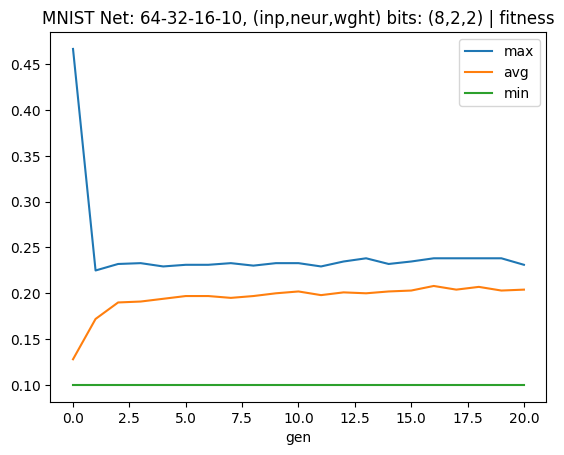

In [194]:
pd.DataFrame(log.chapters['fitness']).plot("gen", ["max","avg","min"])
plt.title(NNstr + " | fitness")

import datetime

now_timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"{now_timestamp_str}_fitness_vs_gen__{NNfile}.png"
plt.gcf().savefig(filename, dpi=100)

In [ ]:
pd.DataFrame(log.chapters['size']).plot("gen", ["max","avg","min"])
plt.title(NNstr + " | size")

In [196]:
def get_true_pred(lbls):
    ret = []
    for l in lbls:
        h = np.zeros(10, dtype=int)
        h[l] += 1
        ret.append(h)
    return np.asarray(ret)
    
# get_true_pred(subtrain_l)

In [197]:

def compute_multihot_histogram(true_labels, predicted_multihot):
    hist = np.zeros((10, 10), dtype=int)
    for t, p in zip(true_labels, predicted_multihot):
        hist[t] += p
    return hist

subtrain_d, subtrain_l =  gen_Data_Label(1000)

h2 = compute_multihot_histogram(subtrain_l, run_NN_from_indi(subtrain_d,indi))

compute_multihot_histogram(subtrain_l, get_true_pred(subtrain_l))

array([[ 89,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 127,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  87,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  93,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  94,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 106,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 112,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 102,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  88,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 102]])

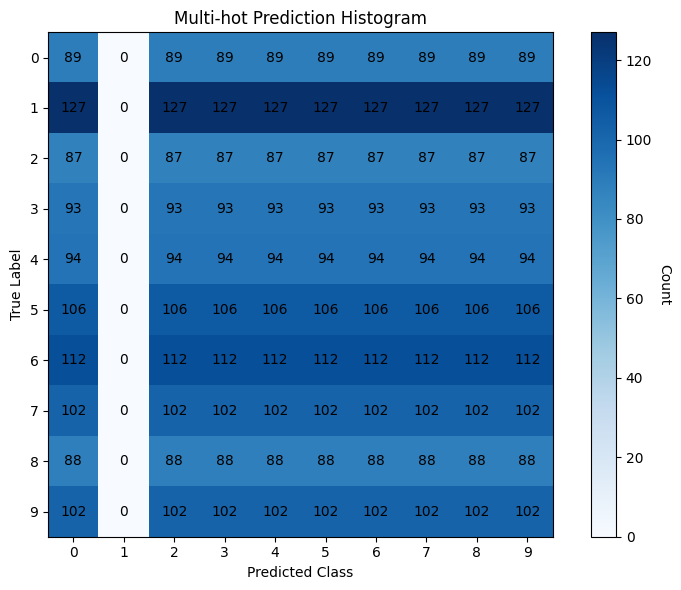

In [198]:
hist = h2
# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(hist, cmap='Blues')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Count", rotation=-90, va="bottom")

# Set axis labels and ticks
ax.set_xlabel("Predicted Class")
ax.set_ylabel("True Label")
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xticklabels(np.arange(10))
ax.set_yticklabels(np.arange(10))

# Annotate each cell with the count
for i in range(10):
    for j in range(10):
        text = ax.text(j, i, hist[i, j], ha="center", va="center", color="black")

plt.title("Multi-hot Prediction Histogram")
plt.tight_layout()
plt.show()


In [ ]:
bins = np.linspace(0,2,21)

In [ ]:
rand = [fitness(rand_indi()) for i in range(10)]

In [ ]:
plt.hist( rand                                                  ,bins=bins , alpha=0.5, color='blue' ,  label="rand")
plt.hist([hof[i].fitness.wvalues[0] for i in range(1,min(10,len(hof)))] ,bins=bins , alpha=0.8, color='green',  label="HoF")
plt.hist([hof[0].fitness.wvalues[0]]                            ,bins=bins , alpha=0.9, color='red'  ,  label="Best")
# plt.hist([test_fitness(rand_indi_custom(0.9)) for i in range(100)] ,bins=bins , alpha=0.5,     label="rand(0.9)")


plt.legend()
plt.xlabel("fitness")
plt.ylabel("#")
plt.title(NNstr + " with Training data")


In [ ]:
gen_Data?

In [ ]:
Train_D_good, Train_D_bad = gen_Data(500,500)
len(Train_D_good), len(Train_D_bad)

In [ ]:
# def fitness_view(indi):
indi = hof[0]
# indi = log_read.genlog[-1]
verbose = False
if indi is not None:
    Train_D_good, Train_D_bad = gen_Data(500,500)

    res_g = run_NN_from_indi(Train_D_good, indi)
    # res_g = np.apply_along_axis(func1d=run_NN, axis=1, arr=Train_D_good, pars=(conv_from_indi_to_wght(indi),conv_from_indi_to_summap(indi) ))
    # plt.hist( (np.float32(np.sum( res , axis=1))) , alpha=0.5,   label="Good")
    plt.hist( [on_target(r,[1,0]) for r in res_g] , alpha=0.5, bins=range(3),  label="Good")
    
    res_b = run_NN_from_indi(Train_D_bad, indi)
    # res_b = np.apply_along_axis(func1d=run_NN, axis=1, arr=Train_D_bad, pars=(conv_from_indi_to_wght(indi), conv_from_indi_to_summap(indi)))
    plt.hist( [on_target(r,[0,1]) for r in res_b] , alpha=0.5, bins=range(3),   label="Bad")


    plt.legend()
    # return good + bad


In [ ]:
on_target(res_b,[0,1])/lenTrain_D_bad

# [on_target(r,[0,1]) for r in res_b]

In [ ]:
class_nr = {(0,1):0,(1,0):1,(1,1):2,(0,0):2}
[class_nr[tuple(i)] for i in [[0,1], [1,0], [1,1], [0,0]]]

def tuple_to_label(tuplist):
    p = np.asarray(tuplist)
    return np.where((p[:, 0] == 1) & (p[:, 1] == 0), 0, np.where((p[:, 0] == 0) & (p[:, 1] == 1), 1, 2))

tuple_to_label(  [[0,1], [1,0], [1,1], [0,0]]  )

In [ ]:
def confusion_matrix(y_true, y_pred, n_classes=3):
    """
    Compute a plain (non‑normalized) confusion matrix.

    Parameters
    ----------
    y_true : array‑like, shape (n_samples,)
        Ground‑truth class indices (0 … n_classes‑1).
    y_pred : array‑like, shape (n_samples,)
        Predicted class indices (same coding as y_true).
    n_classes : int, optional (default=2)
        Number of distinct classes.

    Returns
    -------
    cm : ndarray, shape (n_classes, n_classes)
        cm[i, j] = # of samples whose true label = i and predicted label = j
        (rows = true, columns = predicted)
    """
    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)

    cm = np.zeros((n_classes, n_classes), dtype=int)

    # Efficient vectorised counting:
    #   for each possible pair (i, j) we count how many times it appears.
    for i in range(n_classes):
        for j in range(n_classes):
            cm[i, j] = np.sum((y_true == i) & (y_pred == j))

    return cm


res = tuple_to_label( np.concatenate([res_g,res_b]) )
tru = tuple_to_label( np.concatenate([[[1,0]]*len(res_g),[[0,1]]*len(res_b)]) )
cm = confusion_matrix(res,tru)
cm

In [ ]:
len(Train_D_bad), len(Train_D_good)


In [ ]:
def plot_confusion_matrix(cm,
                          class_names=["Good","Bad","Either"],
                          title='Confusion matrix',
                          cmap='Blues',
                          normalize=False,
                          figsize=(6, 5)):
    """
    Draw a confusion matrix with Matplotlib.

    Parameters
    ----------
    cm : ndarray, shape (n_classes, n_classes)
        The confusion matrix (raw counts or already normalized).
    class_names : list of str, optional
        Human readable names for each class.  If None, uses 0,1,… .
    title : str, optional
    cmap : str or Colormap, optional
        Colormap used for the heat‑map.
    normalize : bool, optional
        If True, each row is normalized to sum to 1 (i.e. per‑class recall).
    figsize : tuple, optional
    """
    if class_names is None:
        class_names = [str(i) for i in range(cm.shape[0])]

    if normalize:
        # Avoid division by zero
        row_sums = cm.sum(axis=1, keepdims=True)
        cm_disp = np.divide(cm, row_sums, where=row_sums != 0)
    else:
        cm_disp = cm

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm_disp, interpolation='nearest', cmap=cmap)

    # Color‑bar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Normalized fraction' if normalize else 'Count',
                       rotation=-90, va="bottom")

    # Tick marks + labels
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=class_names,
        yticklabels=class_names,
        ylabel='True label',
        xlabel='Predicted label',
        title=title
    )

    # Rotate the x‑tick labels for readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Annotate each cell with the numeric value
    thresh = cm_disp.max() / 2.0
    fmt = '.2f' if normalize else 'd'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm_disp[i, j]
            r = ax.text(i, j, format(val, fmt),
                    ha="center", va="center",
                    color="white" if val > thresh else "black")

    fig.tight_layout()
    plt.show()

plot_confusion_matrix(cm)

In [ ]:
cm = confusion_matrix(tuple_to_label( run_NN_from_indi([rand_inp() for i in range(1000)], rand_indi()))  ,[2])
cm


In [ ]:
cm = confusion_matrix(tuple_to_label( run_NN_from_indi([rand_inp() for i in range(1000)], indi))  ,[2])
cm


In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))

# Access with axes[row, col], e.g.:
# axes[0, 0].plot([1, 2, 3], [1, 4, 9])


cnt = 0
clplot = {1:[0,0], 0:[0,1], 2:[0,2]}
for i in zip(tuple_to_label(res_g),Train_D_good):
    # if i[0]==0:
        axes[*clplot[i[0]]].plot(i[1])

clplot = {0:[1,0], 1:[1,1], 2:[1,2]}
for i in zip(tuple_to_label(res_b),Train_D_bad):
    # if np.sum(i[0])==1:
        axes[*clplot[i[0]]].plot(i[1])

plt.tight_layout()
plt.show()

In [ ]:
cnt = 0

for i in zip(res_g,Train_D_good):
    if tuple_to_label([i[0]]) != tuple_to_label([[1,0]]):
        plt.plot(i[1])
        cnt += 1
    if cnt == 10:
        break

In [ ]:
cnt = 0

for i in zip(res_b,Train_D_bad):
    if tuple_to_label([i[0]]) == tuple_to_label([[1,1]]):
        plt.plot(i[1])
        cnt += 1
    if cnt == 10:
        break

# Write to VHDL file

In [ ]:

# del hof

In [ ]:
indi = None
if "hof" in globals():
    indi = hof[0]


In [ ]:
if "hof" in globals():
    indi = hof[0]
else:
    indi = rand_indi()

NNwgth = conv_from_indi_to_wght(indi)
# NNbias = conv_from_indi_to_bias(indi)
NNsummap = conv_from_indi_to_summap(indi)

## Open/Overwrite file

In [ ]:
VHD=open("../BNN_inst.vhd", "w")

In [ ]:
inp_len, "input_width"

In [ ]:
VHD_HEAD=f"""
library IEEE;
use IEEE.STD_LOGIC_1164.ALL;
use IEEE.NUMERIC_STD.ALL;

library work;
use work.BNN_pack.all;


entity BNN_forward is
    Port (
    input_i : in std_logic_vector({NN[0]}*input_width-1 downto 0);
    output_o : out std_logic_vector({NN[-1]}-1 downto 0)
    );
end BNN_forward;

architecture arch_imp of BNN_forward is
"""

VHD.write(VHD_HEAD)
print(VHD_HEAD)
# VHD.close()
# !cat BNN_inst.vhd

In [ ]:
T=f"""
type t_NN_layout  is array (0 to {len(NN)}-1) of integer;
-- max index = width-1 
constant NN_width: t_NN_layout := ({", ".join([f"{i}-1" for i in NN])});
"""

VHD.write(T)
print(T)
# type t_sum_n3 is array (0 to NN_width(3) ) of neursum;
# signal sum_n3: t_sum_n3:= (others => (others => '0'));


# for L in list(range(len(NN)-1))+["f"]:
T=""




T+=f"type t_layer_n{0} is array (0 to NN_width({0}) ) of input_smpl;"
T+="\n"
T+=f"signal layer_n{0}: t_layer_n{0} := (others => (others => '0'));"
T+="\n"
T+="\n"


for L in range(1, len(NN)):
    T+=f"type t_sum_n{L} is array (0 to NN_width({L}) ) of neursum;"
    T+="\n"
    if True:
        T+=f"signal sum_n{L}: t_sum_n{L} := (others => (others => '0'));"
        T+="\n"
        T+=f"type t_layer_n{L} is array (0 to NN_width({L}) ) of neur;"
    T+="\n"
    T+=f"signal layer_n{L}: t_layer_n{L} := (others => (others => '0'));"
    T+="\n"
    # T+=f"type t_bias_n{L} is array (0 to NN_width({L}) ) of bias;"
    # T+="\n"

    T+="\n"


VHD.write(T)
print(T)

T="\n\n"
VHD.write(T)

for L in range(len(NN)-1):
    T+=f"type t_weight_n{L}_n{L+1} is array (0 to NN_width({L+1}) , 0 to NN_width({L}) ) of wght;"
    T+="\n"
VHD.write(T)
print(T)

T="\n\n"
VHD.write(T)


for L in range(1,len(NN)):
    T+=f"type t_summap_n{L} is array (0 to NN_width({L}) ) of neursum_map;"
    T+="\n"
VHD.write(T)
print(T)

T="\n\n"
VHD.write(T)




In [ ]:

# T=""
# for L in range(1,len(NN)):
#     T += f"constant bias_n{L}: t_bias_n{L} := (\n"
#     ll = L
    
#     for i in range(NN[L]):
#         # T += f"b\"{NNbias[L][i*2]}{NNbias[L][i*2+1]}\""  +  ("," if i < NN[L]-1 else "\n")
#         T += f"b\"{np.binary_repr(NNbias[L-1][i],2)}\""  +  (", " if i < NN[L]-1 else "\n")
        
#     T += ");\n" 
#     # T += "\n"
# print(T)

# T+="\n\n"
# VHD.write(T)



In [ ]:
NNwgth[0],NNwgth[1], NNwgth[0].ravel(), NN

In [ ]:
T=""
for L in range(len(NN)-1):
    T = f"constant weight_n{L}_n{L+1}: t_weight_n{L}_n{L+1} := (\n"
    VHD.write(T)
    print(T)
    ll = L
    
    for o in range(NN[ll+1]):
        T = "("
        for i in range(NN[ll]):
            w=np.binary_repr(NNwgth[ll][o][i],2)
            T += f"b\"{w}\"" +  (", " if i < NN[ll]-1 else ")\n")
            # T += f"'{(NNwgth[L].ravel()[i*(NN[ll+1]) +o]+1)//2}'"  +  ("," if o < NN[ll+1]-1 else ")\n")
            # T += f"b\"{np.binary_repr(NNwgth[ll].ravel()[o*(NN[ll+1]) +i],2)}\" {o,i,o*(NN[ll]) +i}"  +  (", " if i < NN[ll+1]-1 else ")\n")
            # T += f"'{(NNwgth[L].ravel()[i*(NN[ll+1]) +o]+1)//2}'"  +  ("," if o < NN[ll+1]-1 else ")\n")
        
        T += ("," if o < NN[ll+1]-1 else ");") + "\n" 
        VHD.write(T)
        print(T)

    T = "\n"
    print(T)
    VHD.write(T)




T="\n\n"
VHD.write(T)
print(T)



In [ ]:
NNsummap[0][0]

In [ ]:
# t_summap_n1
T=""
for L in range(1,len(NN)):
    T += f"constant summap_n{L}: t_summap_n{L} := ( "
    # for o in range(NN[L]):
    T += ','.join( [  f"({ ','.join( map(str,s)) })"  for s in NNsummap[L-1]] )
    # T += f"{'),\n('.join( map(str,s )) }"
    # T += f"{-int(NN[L]/2)} , {int(NN[L]/2)} , {int(NN[L]*3/2)}"       
    # T += f"{int(NN[L]*3*1/4)} , {int(NN[L]*3*1/2)} , {int(NN[L]*3*3/4)}"       
    
    T += ");\n" 
print(T)

T+="\n\n"
VHD.write(T)

"""
constant summap_n1 : neursum_map := ( -128/2, 128/2 , 128*3/2 );
constant summap_n2 : neursum_map := ( -60/2, 60/2 , 60*3/2 );
constant summap_n3 : neursum_map := ( -24/2, 24/2 , 24*3/2 );
"""
1

In [ ]:
T="\nattribute KEEP : string;\n"
T += f"{"" if keep_l[0] else "-- "}attribute KEEP of layer_n{0} : signal is \"TRUE\";\n"
for L in range(1,len(NN)-1):
    T += f"{"" if keep_l[L] else "-- "}attribute KEEP of layer_n{L} : signal is \"TRUE\";\n"
T += f"{"" if keep_l[len(NN)-1] else "-- "}attribute KEEP of layer_n{len(NN)-1} : signal is \"TRUE\";\n"

print(T)

T+="\n\n"
VHD.write(T)



In [ ]:
T="\n\nbegin\n\n"
VHD.write(T)

In [ ]:
T=""
for n in range(NN[0]):
    if False:
        T += f"layer_n0({n}) <= input_i({n});-- & not input_i({n});\n"
        T += f"layer_n0({n}) <= input_i({n}) & not input_i({n});\n"
    else:
        T += f"layer_n0({n}) <= unsigned(  input_i({(n+1)*inp_len}-1 downto {n*inp_len}) ) ;\n"

T+="\n\n"

for n in range(NN[-1]):
    # output_o(0) <= '1' when unsigned( layer_n3(0) ) > 1 else '0';
    # output_o(1) <= '1' when unsigned( layer_n3(1) ) > 1 else '0';
    T += f"output_o({n}) <= layer_n{len(NN)-1}({n})(1);\n"
    # T += f"output_o({n+1}) <= layer_n{len(NN)-1}({n})(1);\n"

print(T)

T+="\n\n"
VHD.write(T)


### Main layer calc

In [ ]:
L=0
T=""
T += f"calc_layer_n{L+1}:   for n{L+1} in 0 to NN_width({L+1}) generate\n"
T += f"sum_n{L+1}(n{L+1}) <= \n"
n2 = int( 2**np.ceil(np.log2(NN[L])) )
S=["" for i in range(n2+1)]
for i in range(n2+1):
    S[i] += "+"


for B in range( 1, int(np.log2(n2))+1 ):
    for i in range( int((n2+1)/(2**B))+1 ):
        S[i*(2**B)] = ")" + S[i*(2**B)] + "("
    
# print (S)

S[0] = S[0].split('+')[1]
S[-1] = S[-1].split('+')[0]
# print (S)


for i in range(NN[L]):
    T += f" {S[i]} \n inp_ws(layer_n{L}({i}),weight_n{L}_n{L+1}(n{L+1},{i})) \n"
for i in range(NN[L],n2):
    T += f" {S[i]} \n 0 \n"
T += f" {S[-1]};\n"
### nested sum with brackets


# T += f"layer_n{L+1}(n{L+1}) <= neur_b( neur_act( sum_n{L+1}(n{L+1}) , summap_n{L+1}), bias_n{L+1}(n{L+1}) );\nend generate;\n" 
T += f"layer_n{L+1}(n{L+1}) <= neur_act( sum_n{L+1}(n{L+1}) , summap_n{L+1}(n{L+1})) ;\nend generate;\n" 
T += "\n"
print(T)
VHD.write(T)


for L in range(1, len(NN)-1):
    T=""
    T += f"calc_layer_n{L+1}:   for n{L+1} in 0 to NN_width({L+1}) generate\n"
    T += f"sum_n{L+1}(n{L+1}) <= \n"
    n2 = int( 2**np.ceil(np.log2(NN[L])) )
    S=["" for i in range(n2+1)]
    for i in range(n2+1):
        S[i] += "+"
    
    
    for B in range( 1, int(np.log2(n2))+1 ):
        for i in range( int((n2+1)/(2**B))+1 ):
            S[i*(2**B)] = ")" + S[i*(2**B)] + "("
        
    # print (S)

    S[0] = S[0].split('+')[1]
    S[-1] = S[-1].split('+')[0]
    # print (S)

    
    # for i in range(NN[L]):
    #     T += f" {S[i]} \n {i} \n"
    # for i in range(NN[L],n2):
    #     T += f" {S[i]} \n {i}*0 \n"
    # T += f" {S[-1]}\n"
    # print(T)
    
    # break
    
    for i in range(NN[L]):
        T += f" {S[i]} \n neur_ws(layer_n{L}({i}),weight_n{L}_n{L+1}(n{L+1},{i})) \n"
    for i in range(NN[L],n2):
        T += f" {S[i]} \n 0 \n"
    T += f" {S[-1]};\n"
    ### nested sum with brackets


    # T += f"layer_n{L+1}(n{L+1}) <= neur_b( neur_act( sum_n{L+1}(n{L+1}) , summap_n{L+1}), bias_n{L+1}(n{L+1}) );\nend generate;\n" 
    T += f"layer_n{L+1}(n{L+1}) <= neur_act( sum_n{L+1}(n{L+1}) , summap_n{L+1}(n{L+1})) ;\nend generate;\n" 
    T += "\n"
    print(T)
    VHD.write(T)

T="\n\nend arch_imp;\n\n"
print(T)


VHD.write(T)




In [ ]:
# neur_ws(layer_n0(0),weight_n0_n1(0,n1)) 

In [ ]:
VHD.close()


## Finished VHDL

In [ ]:
import numpy as np

arr = np.random.randint(0, 128, size=128)

def wf_to_vhdl(arr):
    # Concatenate into one big binary string, MSB of each element first
    bitstring = "".join(f"{val:07b}" for val in arr[::-1])
    
    # Wrap to 80 chars per line for readability in VHDL
    lines = [bitstring[i:i+7*8] for i in range(0, len(bitstring), 7*8)]
    vhdl_str = "constant stimulus : std_logic_vector(895 downto 0) :=\n"
    vhdl_str += " &\n".join(f'  "{line}"' for line in lines) + ";"
    print(arr)
    print(vhdl_str)



In [ ]:
a = SiPM_inp()
wf_to_vhdl( a )


In [ ]:
conv_from_indi_to_wght(indi)[0]

In [ ]:
a = [8,8,22,32,38,42,45,46,46,45,44,42,41,39,37,35,33,32,30,28,27,25,24,23,21,20,19,18,18,17,16,15,15,14,14,13,13,12,12,11,11,11,11,10,10,10,10,10,9,9,9,9,9,9,9,9,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8]
a = np.asarray(a)

In [ ]:
verbose = True
# run_NN_from_indi([a], indi)



def run_NN_verbose(inp, pars):
    global NN
    # NN, NNwgth, NNbias, NNsummap = pars
    NNwgth,NNsummap  = pars
    layer_ni = inp #layer_inp(inp)
    print(layer_ni)
    for i in range(0,len(NN)-1):
        layer_ni = calc_layer( layer_ni, i, NNwgth,  NNsummap)
        print(layer_ni)
    return output_o(layer_ni)

# run_NN(rand_inp(NN[0]), pars=(NNwgth,NNsummap)), \
verbose = True
# run_NN(rand_inp(NN[0]), pars=(NNwgth,conv_from_indi_to_summap(rand_indi()) )), \
run_NN_verbose(a, pars=(conv_from_indi_to_wght(indi),conv_from_indi_to_summap(indi) ))


In [ ]:
a = Nois_inp()
wf_to_vhdl( a )


run_NN_verbose(a, pars=(conv_from_indi_to_wght(indi),conv_from_indi_to_summap(indi) ))


In [ ]:
len( np.ones(NN[0]) ), len(  np.array(list(np.binary_repr(random.getrandbits( NN[0] ), width=NN[0])), dtype=np.uint8)    ) 

# End

### Neuron behaviour to HDL snippets

In [ ]:
import numpy as np

In [ ]:
## Outdated
# BNN_val = { 
#     -1: "10" ,
#      0: "00" ,
#      1: "01" ,
#      2: "11" ,
# }    
BNN_val = { 
     0: "00" ,
     1: "01" ,
     2: "10" ,
     3: "11" ,
}    
BNN_val[1]

In [ ]:
## Outdated
"""
# Bias
n + 00 => 00
n + 01 => n-1
n + 02 => n
n + 03 => n+1
"""


In [ ]:
## Outdated
def BNN_plus(a,b):
    plus_d = {
        frozenset({-1} ) : -1,
        frozenset({0} )  :  0,
        frozenset({1} )  :  1,
        frozenset({2} )  :  2,
        frozenset({-1,0} ) : -1,
        frozenset({-1,1} ) : 0,
        frozenset({-1,2} ) : 0,
        frozenset({0,1} )  :  1,
        frozenset({0,2} )  :  1,
        frozenset({1,2} )  :  2,    
    }
    return plus_d[frozenset({a,b} )]


def BNN_plus(a,b):
    plus_d = {
        frozenset({0} )    :  0,
        frozenset({1} )    :  1,
        frozenset({2} )    :  2,
        frozenset({3} )    :  3,
        frozenset({0,1} )  :  0,
        frozenset({0,2} )  :  1,
        frozenset({0,3} )  :  1,
        frozenset({1,2} )  :  2,
        frozenset({1,3} )  :  2,
        frozenset({2,3} )  :  3,    
    }
    return plus_d[frozenset({a,b} )]

BNN_plus(1,2)



In [ ]:
## Outdated

a = [-1,0,1,2]
a = [0,1,2,3]
# comb = []
for i in a:
    for o in a:
        # comb.append( frozenset([i,o]) )
        print("{: 2d}".format( BNN_plus(i,o) ), end="")
    print()
# frozenset(comb)

for i in a:
    for o in a:
        print(' when "{:s}{:s}" => res := "{:s}";'.format( BNN_val[i], BNN_val[o], BNN_val[BNN_plus(i,o)] ) )
